In [1981]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import constants
import itertools
import skrf as rf
import pandas as pd
import pickle

%config InlineBackend.figure_format = 'svg'
plt.rcParams['lines.linewidth'] = 0.8

In [1982]:
epsilon_0 = constants.epsilon_0

In [1983]:
fstart = -10
fstop = 25
fpoints = 250

f = np.logspace(fstart, fstop, fpoints)

W = 3 mm  
S = 1 mm

L = 43.18 mm

In [1984]:
def Z_eff_2_L_C(Z0o, Z0e, eps_o, eps_e):
    c = constants.speed_of_light

    Lo = (Z0o/c)*np.sqrt(eps_o)
    Co = np.sqrt(eps_o)/(c*Z0o)

    Le = (Z0e/c)*np.sqrt(eps_e)
    Ce = np.sqrt(eps_e)/(c*Z0e)
    
    Ca = Ce
    Cm = (Co+Ce)/2

    return Lo, Co, Le, Ce, Ca, Cm


In [1985]:
Lo, Co, Le, Ce, Ca, Cm = Z_eff_2_L_C(8.9, 12.21, 3.08*epsilon_0, 3.46*epsilon_0)

print(Lo, Co, Le, Ce, Ca, Cm)

1.5503117082125037e-13 1.9572171546679755e-15 2.2542774948359541e-13 1.5120844508810489e-15 1.5120844508810489e-15 1.7346508027745123e-15


In [1986]:
L = 1e-7
Cm1 = 3e-2
Cm2 = 3e-5
Ca = 3e-20

In [1987]:
num_of_sections = 8
num_of_combinations = 2**num_of_sections

# Generate all possible combinations of an 8-bit input
input_combinations = list(itertools.product([0, 1], repeat=8))

# Convert the combinations to a NumPy array
input_matrix = np.array(input_combinations)

Cm = input_matrix*Cm1 + (1-input_matrix)*Cm2 # capacitance values for every single state

In [1988]:
Cm

array([[3.e-05, 3.e-05, 3.e-05, ..., 3.e-05, 3.e-05, 3.e-05],
       [3.e-05, 3.e-05, 3.e-05, ..., 3.e-05, 3.e-05, 3.e-02],
       [3.e-05, 3.e-05, 3.e-05, ..., 3.e-05, 3.e-02, 3.e-05],
       ...,
       [3.e-02, 3.e-02, 3.e-02, ..., 3.e-02, 3.e-05, 3.e-02],
       [3.e-02, 3.e-02, 3.e-02, ..., 3.e-02, 3.e-02, 3.e-05],
       [3.e-02, 3.e-02, 3.e-02, ..., 3.e-02, 3.e-02, 3.e-02]])

In [1989]:
# Assume negligible looses
R = 1e-6
Gm = 1e-8
Ga = 1e-10

l = 1e-4 / num_of_sections # length of each line

In [1990]:
def invert_mat(A):
    inv_A = np.zeros((len(A[0, :, 0]), len(A[:, 0, 0]), len(A[0, 0, :])), dtype=complex)
    for i in range(len(A[0, 0])):
        inv_A[:, :, i] = np.linalg.inv(A[:, :, i])

    return inv_A

def multiply_mat(A, B):
    C = np.zeros((len(A[0, :, 0]), len(A[:, 0, 0]), len(A[0, 0, :])), dtype=complex)
    for i in range(len(A[0, 0, :])):
        C[:, :, i] = A[:, :, i] @ B[:, :, i]

    return C

In [1991]:
# Define odd and even mode parameters

def odd_mode_params(f, L, Cm, Ca, Gm, Ga):
    w = 2*np.pi*f
    Co = 2*Cm - Ca
    Go = 2*Gm + Ga
    Lo = L*(1-1e-3)
    Ro = R
    gamma_o = 1e-5 + 1j*(2*np.pi*w*np.sqrt(Lo*Co))
    Z0o = np.sqrt((Ro+1j*w*Lo)/(Go + 1j*w*Co))


    f0_o = 1/(2*np.pi*np.sqrt(Lo/Co)) # frequency at which the coupled lines are a quarter-wavelength long electrically when excited in the odd mode
    theta_o = (np.pi/2)*(f/f0_o)

    return Lo, Co, Go, Ro, gamma_o, Z0o, theta_o

def even_mode_params(f, L, Cm, Ca, Gm, Ga):
    w = 2*np.pi*f
    Ce = Ca
    Ge = Ga
    Le = L*(1+1e-3)
    Re = R
    gamma_e = 1e-4 + 1j*(2*np.pi*w*np.sqrt(Le*Ce))
    Z0e = np.sqrt((Re+1j*w*Le)/(Ge + 1j*w*Ce))

    f0_e = 1/(2*np.pi*np.sqrt(Le/Ce)) #frequency at which the coupled lines are a quarter-wavelength long electrically when excited in the even mode,
    theta_e = (np.pi/2)*(f/f0_e)

    return Le, Ce, Ge, Re, gamma_e, Z0e, theta_e

def create_Z_matrix(Z0e, cot_theta_e, csc_theta_e, Z0o, cot_theta_o, csc_theta_o):

    Z11 = -(1j/2) * (Z0e*cot_theta_e + Z0o*cot_theta_o)
    Z12 = -(1j/2) * (Z0e*cot_theta_e - Z0o*cot_theta_o)
    Z13 = -(1j/2) * (Z0e*csc_theta_e - Z0o*csc_theta_o)
    Z14 = -(1j/2) * (Z0e*csc_theta_e + Z0o*csc_theta_o)

    Z = np.zeros((4, 4, len(Z11)), dtype=complex)

    Z[0][0][:] = Z11
    Z[1][1][:] = Z[0][0][:]
    Z[2][2][:] = Z[0][0][:]
    Z[3][3][:] = Z[0][0][:]

    Z[0][1][:] = Z12
    Z[1][0][:] = Z[0][1][:]
    Z[2][3][:] = Z[0][1][:]
    Z[3][2][:] = Z[0][1][:]

    Z[0][2][:] = Z13
    Z[2][0][:] = Z[0][2][:]
    Z[1][3][:] = Z[0][2][:]
    Z[3][1][:] = Z[0][2][:]

    Z[0][3][:] = Z14
    Z[3][0][:] = Z[0][3][:]
    Z[1][2][:] = Z[0][3][:]
    Z[2][1][:] = Z[0][3][:]

    return Z

def find_Zin(ZL, Zc, beta, l):
    return Zc * ( (ZL + 1j*Zc*np.tan(beta*l))/(Zc + 1j*ZL*np.tan(beta*l)) )

def find_imput_impedances(num_of_sections, index, L, C_curr, l, f):
    if (index == num_of_sections-1):
        Z03 = 50*np.ones(len(f))
    else:
        Z03 = 50*np.ones(len(f))
        while(index != num_of_sections-1):
            Z03 = find_Zin(Z03, np.sqrt(L/C_curr[index]), 2*np.pi*np.sqrt(L*C_curr[index]), l)
            index += 1

    if (index == 0):
        Z01 = 50*np.ones(len(f))
    else:
        temp = 0
        Z01 = 50*np.ones(len(f))
        while(temp != index-1):
            Z01 = find_Zin(Z03, np.sqrt(L/C_curr[index]), 2*np.pi*np.sqrt(L*C_curr[index]), l)
            temp += 1
    
    Z02 = Z01
    Z04 = Z03
    return Z01, Z02, Z03, Z04

def create_charc_impedance_array(L, C):
    return np.sqrt(L/C)
    

def create_F(Z01, Z02, Z03, Z04):
    F = np.zeros((4, 4, len(Z01)), dtype=complex)
    F[0][0][:] = 1/(2*np.sqrt(Z01))
    F[1][1][:] = 1/(2*np.sqrt(Z02))
    F[2][2][:] = 1/(2*np.sqrt(Z03))
    F[3][3][:] = 1/(2*np.sqrt(Z04))
    return F

def create_G(Z01, Z02, Z03, Z04):
    G = np.zeros((4, 4, len(Z01)), dtype=complex)
    G[0][0][:] = Z01
    G[1][1][:] = Z02
    G[2][2][:] = Z03
    G[3][3][:] = Z04
    return G

def z2s(Z, F, G):
    # Calculate Z - G* and Z + G
    Z_minus_G_star = Z - np.conj(G)
    Z_plus_G = Z + G
    
    # Calculate the inverse of Z + G
    Z_plus_G_inv = invert_mat(Z_plus_G)
    
    # Calculate F^(-1)
    F_inv = invert_mat(F)
    
    # Calculate S = F(Z - G*)(Z + G)^(-1)F^(-1)
    S = multiply_mat(multiply_mat(F, Z_minus_G_star), multiply_mat(Z_plus_G_inv, F_inv))
    
    return S

def s2z(S, F, G):
    # Calculate the identity matrix I of the same shape as S
    I = np.zeros(S.shape, dtype=complex)
    for i in range(S.shape[2]):
        I[:, :, i] = np.eye(4, dtype=complex)
    
    # Calculate (I - S)^(-1)
    I_minus_S_inv = invert_mat(I - S)
    
    # Calculate SG + G*
    SG_plus_G_star = multiply_mat(S, G) + np.conj(G)
    
    # Calculate F^(-1)
    F_inv = invert_mat(F)
    
    # Calculate Z = F^(-1)(I - S)^(-1)(SG + G*)F
    Z = multiply_mat(multiply_mat(F_inv, I_minus_S_inv), multiply_mat(SG_plus_G_star, F))
    
    return Z

def display_parameters(f ,L, C, G, R, gamma, Z0, theta):
    print("L = ", L)
    print("C = ", C)
    print("G = ", G)
    print("R = ", R)

    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.semilogx(f, np.abs(gamma))
    plt.grid()
    plt.xlabel("f")
    plt.ylabel("$\gamma$")

    plt.subplot(2, 2, 2)
    plt.semilogx(f, np.abs(Z0))
    plt.grid()
    plt.xlabel("f")
    plt.ylabel("$Z_0$")

    plt.subplot(2, 2, 3)
    plt.semilogx(f, theta)
    plt.grid()
    plt.xlabel("f")
    plt.ylabel("$\Theta$")

    '''plt.subplot(2, 2, 4)
    plt.semilogx(f[0:np.floor(len(f)/5)], theta[0:np.floor(len(f)/5)])
    plt.grid()
    plt.xlabel("f")
    plt.ylabel("$\Theta$")'''

def s2abcd(S, Z0):
    ABCD = np.zeros((2, 2, len(f)), dtype=complex)
    S11 = S[0, 0, :]
    S12 = S[0, 1, :]
    S21 = S[1, 0, :]
    S22 = S[1, 1, :]
    ABCD[0, 0, : ] = ( (1+S11)*(1-S22) + S12*S21 )/( 2*S21 )
    ABCD[0, 1, :] = Z0* ( (1+S11)*(1+S22) - S12*S21 )/( 2*S21 )
    ABCD[1, 0, :] = (1/Z0) * ( (1+S11)*(1+S22) - S12*S21 )/( 2*S21 )
    ABCD[1, 1, :] = ( (1-S11)*(1+S22) + S12*S21 )/( 2*S21 )

    return ABCD

In [1992]:
def create_reduced_F(f):
    F = np.zeros((2, 2, len(f)), dtype=complex)
    F[0][0][:] = 1/(2*np.sqrt(50))
    F[1][1][:] = 1/(2*np.sqrt(50))

    return F

def create_reduced_G(f):
    G = np.zeros((2, 2, len(f)), dtype=complex)
    G[0][0][:] = 50
    G[1][1][:] = 50

    return G

def plot_S_params(f, S11, S12, S21, S22):
    gridSize = int(np.ceil(np.sqrt(4)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(10, 10))
    ax.flat[0].semilogx(f, 20*np.log10(np.abs(S11)))
    ax.flat[0].set_xlabel("f")
    ax.flat[0].set_ylabel("$S_{11}$")
    ax.flat[0].grid(True)  # Add grid lines

    ax.flat[1].semilogx(f, 20*np.log10(np.abs(S12)))
    ax.flat[1].set_xlabel("f")
    ax.flat[1].set_ylabel("$S_{12}$")
    ax.flat[1].grid(True)  # Add grid lines

    ax.flat[2].semilogx(f, 20*np.log10(np.abs(S21)))
    ax.flat[2].set_xlabel("f")
    ax.flat[2].set_ylabel("$S_{21}$")
    ax.flat[2].grid(True)  # Add grid lines

    ax.flat[3].semilogx(f, 20*np.log10(np.abs(S22)))
    ax.flat[3].set_xlabel("f")
    ax.flat[3].set_ylabel("$S_{22}$")
    ax.flat[3].grid(True)  # Add grid lines
    plt.show()


def plot_S_params(f, S11, S12, S21, S22):
    gridSize = int(np.ceil(np.sqrt(4)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(10, 10))
    ax.flat[0].semilogx(f, 20*np.log10(np.abs(S11)))
    ax.flat[0].set_xlabel("f")
    ax.flat[0].set_ylabel("$S_{11}$")
    ax.flat[0].grid(True)  # Add grid lines

    ax.flat[1].semilogx(f, 20*np.log10(np.abs(S12)))
    ax.flat[1].set_xlabel("f")
    ax.flat[1].set_ylabel("$S_{12}$")
    ax.flat[1].grid(True)  # Add grid lines

    ax.flat[2].semilogx(f, 20*np.log10(np.abs(S21)))
    ax.flat[2].set_xlabel("f")
    ax.flat[2].set_ylabel("$S_{21}$")
    ax.flat[2].grid(True)  # Add grid lines

    ax.flat[3].semilogx(f, 20*np.log10(np.abs(S22)))
    ax.flat[3].set_xlabel("f")
    ax.flat[3].set_ylabel("$S_{22}$")
    ax.flat[3].grid(True)  # Add grid lines
    plt.show()

In [1993]:
def plot_ABCD(f, A, B, C, D):
    gridSize = int(np.ceil(np.sqrt(4)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(10, 10))
    ax.flat[0].semilogx(f, 20 * np.log10(np.abs(A)))
    ax.flat[0].set_xlabel("f")
    ax.flat[0].set_ylabel("$20 \cdot \log_{10}(A)$")
    ax.flat[0].grid(True)  # Add grid lines

    ax.flat[1].semilogx(f, 20 * np.log10(np.abs(B)))
    ax.flat[1].set_xlabel("f")
    ax.flat[1].set_ylabel("$20 \cdot \log_{10}(B)$")
    ax.flat[1].grid(True)  # Add grid lines

    ax.flat[2].semilogx(f, 20 * np.log10(np.abs(C)))
    ax.flat[2].set_xlabel("f")
    ax.flat[2].set_ylabel("$20 \cdot \log_{10}(C)$")
    ax.flat[2].grid(True)  # Add grid lines

    ax.flat[3].semilogx(f, 20 * np.log10(np.abs(D)))
    ax.flat[3].set_xlabel("f")
    ax.flat[3].set_ylabel("$20 \cdot \log_{10}(D)$")
    ax.flat[3].grid(True)  # Add grid lines

    plt.show()

In [1994]:
# Create a dictionary to store Z parameters for each 'i'
Z_parameters = {}

# Define the file path to save the data
file_path = 'Z_parameters_4_port.pkl'

In [1995]:
print(input_matrix[128][:])

[1 0 0 0 0 0 0 0]


In [1996]:
for i in range(128, 129):
    for j in range(num_of_sections):

        Lo, Co, Go, Ro, gamma_o, Z0o, theta_o = odd_mode_params(f, L, Cm[i][num_of_sections - j - 1], Ca, Gm, Ga)
        Le, Ce, Ge, Re, gamma_e, Z0e, theta_e = even_mode_params(f, L, Cm[i][num_of_sections - j - 1], Ca, Gm, Ga)

        Y0e = 1/(Z0e)
        Y0o = 1/(Z0o)

        cot_theta_o = 1/np.tan(theta_o)
        cot_theta_e = 1/np.tan(theta_e)

        csc_theta_o = 1/np.sin(theta_o)
        csc_theta_e = 1/np.sin(theta_e)

        Z = create_Z_matrix(Z0e, cot_theta_e, csc_theta_e, Z0o, cot_theta_o, csc_theta_o)
        Z01, Z02, Z03, Z04 = find_imput_impedances(num_of_sections, j, L, Cm[i][:], l, f)
        F = create_F(Z01, Z02, Z03, Z04)
        G = create_G(Z01, Z02, Z03, Z04)

        S_curr = z2s(Z, F, G) # convert to S parameters for cascading
        if (j == num_of_sections - 1):
            S = S_curr
        else:
            S = multiply_mat(S_curr, S)
        

    # update F and G
    F = create_F(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))
    G = create_G(50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)), 50*np.ones(len(f)))

    Z = s2z(S, F, G)
    Z_parameters[i] = Z

# Save the Z parameters to a file using pickle
with open(file_path, 'wb') as file:
    pickle.dump(Z_parameters, file)

# Low Pass Filters in Transmission Coefficient

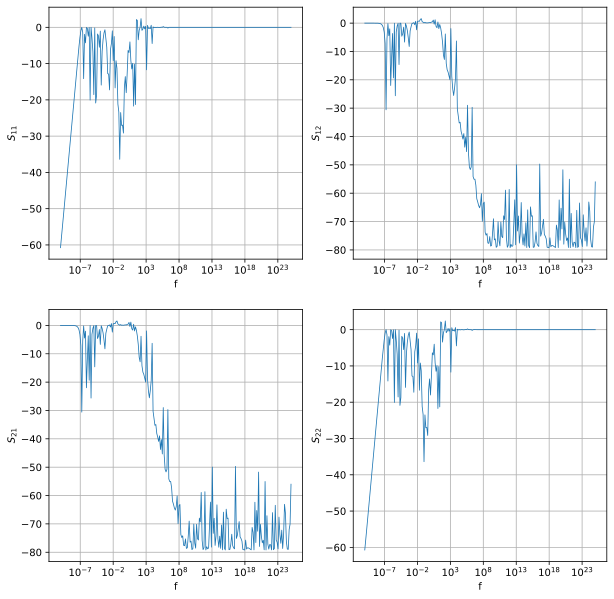

In [1997]:
# V2 = 0 and I3 = 0 - reduces the matrix to that of a 2 port system

def reduce_low_pass(Z):
    return Z[np.ix_([0, 3], [0, 3])]

Z_lpf = reduce_low_pass(Z)
S_lpf = z2s(Z_lpf, create_reduced_F(f), create_reduced_G(f))

plot_S_params(f, S_lpf[0, 0, :], S_lpf[0, 1, :], S_lpf[1, 0, :], S_lpf[1, 1, :])

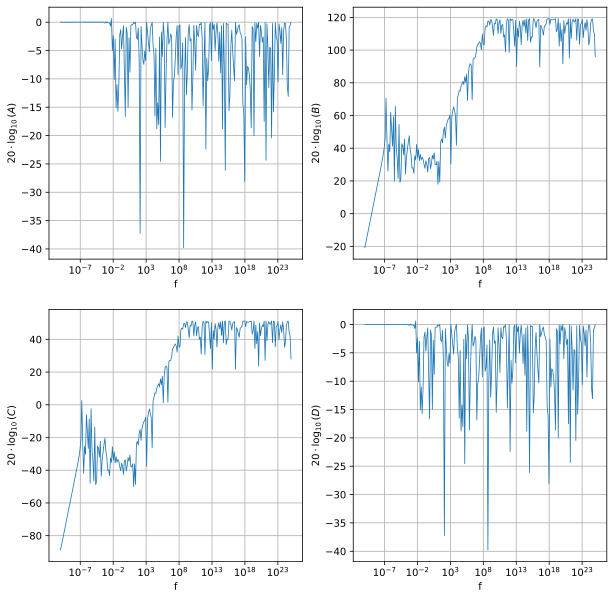

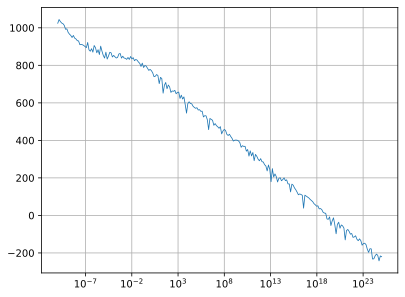

In [1998]:
ABCD = s2abcd(S_lpf, 50)

plot_ABCD(f, ABCD[0, 0, :], ABCD[0, 1, :], ABCD[1, 0, :], ABCD[1, 1, :])

beta = np.imag((1/l*num_of_sections) * np.arccosh((ABCD[0, 0, :] + ABCD[1, 1, :])/2))

e_eff = ((beta*constants.speed_of_light)/(2*np.pi*f))**2

plt.figure()
plt.semilogx(f, 20*np.log10(np.abs(e_eff/constants.epsilon_0)))
plt.grid()

# Band Pass Filters in Transmission Coefficient

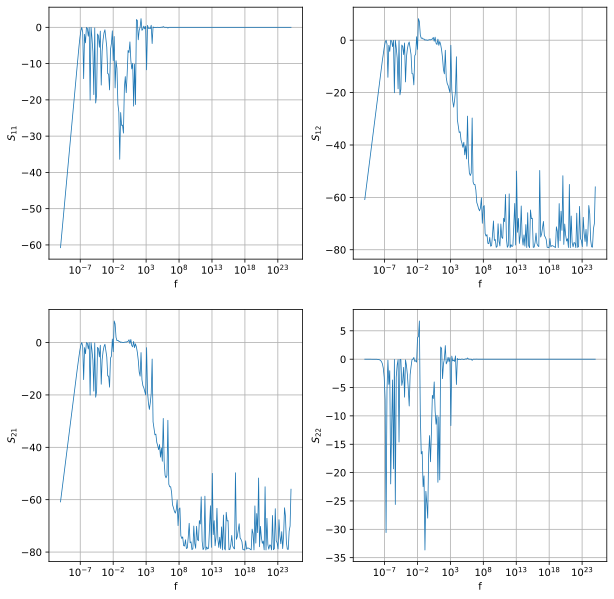

In [1999]:
# I2 = 0 and I4 = 0 - reduces the matrix to that of a 2 port system

def reduce_band_pass(Z):
    return Z[np.ix_([0, 2], [0, 2])]

Z_bpf = reduce_band_pass(Z)

S_bpf = z2s(Z_bpf, create_reduced_F(f), create_reduced_G(f))
plot_S_params(f, S_lpf[0, 0, :], S_bpf[0, 1, :], S_bpf[1, 0, :], S_bpf[1, 1, :])

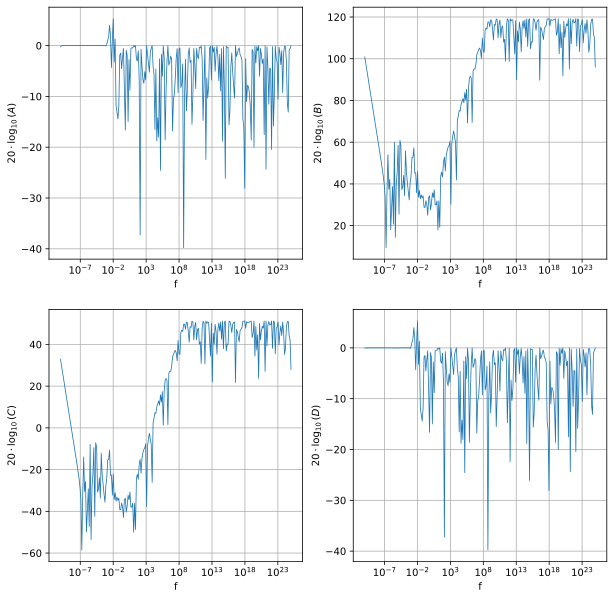

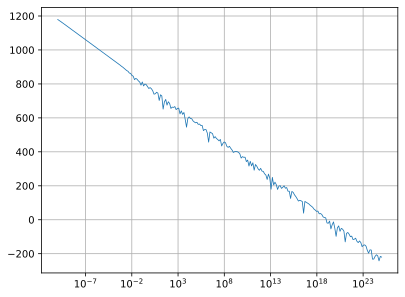

In [2000]:
ABCD = s2abcd(S_bpf, 50)

plot_ABCD(f, ABCD[0, 0, :], ABCD[0, 1, :], ABCD[1, 0, :], ABCD[1, 1, :])

beta = np.imag((1/l*num_of_sections) * np.arccosh((ABCD[0, 0, :] + ABCD[1, 1, :])/2))

e_eff = ((beta*constants.speed_of_light)/(2*np.pi*f))**2

plt.figure()
plt.semilogx(f, 20*np.log10(np.abs(e_eff/constants.epsilon_0)))
plt.grid()